# Basic classification: Classify images of number


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


## Import the MNIST dataset


MNIST 影像資料包括四個檔案：

1.  train_images 訓練影像 60000x28x28
2.  train_labels 訓練影像之標記 60000x1
3.  test_images 測試影像
4.  test_labels 測試影像之標記


In [2]:
# fashion_mnist = tf.keras.datasets.mnist
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Explore the data

訓練影像包含 60,000 個 28x28 尺寸的灰階影像


In [13]:
print(train_images.shape)
train_images.dtype

(60000, 28, 28)


dtype('float64')

Likewise, there are 60,000 labels in the training set:


In [14]:
len(train_labels)

60000

標記是 0 到 9 之間的整數


In [15]:
print(train_labels)
print(train_labels[:10])  # 頭10筆
print(train_labels[-10:])  # 末尾10筆

[5 0 4 ... 5 6 8]
[5 0 4 1 9 2 1 3 1 4]
[9 2 9 5 1 8 3 5 6 8]


測試影像包含 10,000 個 28x28 尺寸的灰階影像


In [16]:
test_images.shape  # 尺寸=(影像數量,影像高,影像寬)

(10000, 28, 28)

測試影像有 10,000 個標記


In [17]:
len(test_labels)

10000

## Preprocess the data

灰階影像的數在 0 到 255 之間


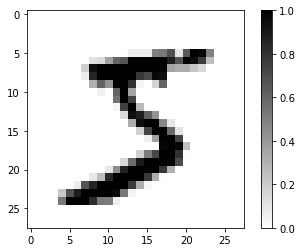

In [18]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)  # 顯示第0號影像，以灰階色彩對映表上色顯示
plt.colorbar()  # 顯示灰階
plt.grid(False)
plt.show()

神經網路必須輸入[0 1]之間的數據, 因此必須將 8 位元灰階影像除以 255.0


In [19]:
train_images = train_images / 255.0  # 將訓練影像明暗調至[0 1]範圍
test_images = test_images / 255.0  # 將測試影像明暗調至[0 1]範圍
test_images.dtype

dtype('float64')

為了確認影像輸入沒有問題，先顯示訓練集的前 25 個影像


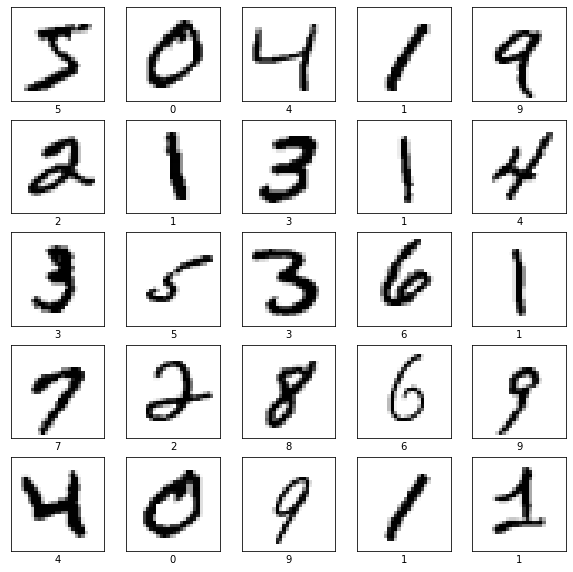

In [20]:
plt.figure(figsize=(10, 10))  # 圖片大小
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)  # 以灰階格式顯示影像
    plt.xlabel(class_names[train_labels[i]])  # 標註影像名稱
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.


### Set up the layers

The basic building block of a neural network is the _layer_. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.


In [23]:
model = tf.keras.Sequential([
    # 將輸入層匯入的28x28像素的灰階影像平坦化(忽略維度)
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),  # 全連接層，使用relu做激勵函數
    tf.keras.layers.Dense(10)  # 全連接層輸出
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 \* 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's _compile_ step:

- _Loss function_ —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- _Optimizer_ —This is how the model is updated based on the data it sees and its loss function.
- _Metrics_ —Used to monitor the training and testing steps. The following example uses _accuracy_, the fraction of the images that are correctly classified.


In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training, call the `model.fit` method—so called because it "fits" the model to the training data:


In [25]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1669 - accuracy: 0.7317
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4813 - accuracy: 0.8753
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3789 - accuracy: 0.8959: 1s - loss: 0
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3378 - accuracy: 0.9046
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3135 - accuracy: 0.9104


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.


### Evaluate accuracy

Next, compare how the model performs on the test dataset:


In [26]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.2953 - accuracy: 0.9132 - 478ms/epoch - 2ms/step

Test accuracy: 0.9132000207901001


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents _overfitting_. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

- [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)


### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret.


In [27]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])  # 轉換為機率值

In [28]:
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:


In [30]:
print(predictions[0])  # 第0號測試影像的預測機率值
print(np.sum(predictions[0]))  # 第0號測試影像的分類機率總和

[6.7591594e-05 7.7192503e-08 2.4840696e-05 6.6288112e-04 1.3168465e-06
 2.8743993e-05 5.6922054e-09 9.9731332e-01 1.1125085e-05 1.8900437e-03]
0.99999994


A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:


In [31]:
print(np.argmax(predictions[0]))  # 取最大值的位置(模式分類編號)
print(np.argmin(predictions[0]))  # 取最小值的位置

7
6


So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:


In [32]:
test_labels[0]  # 目標值(分類編號)

7

Graph this to look at the full set of 10 class predictions.


In [ ]:
def plot_image(i, predictions_array, true_label, img):  # 顯示影像與圖說
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)  # 以灰階形式顯示影像

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:  # 邏輯判斷：是否答對
        color = 'blue'  # 答對時，字用藍色
    else:
        color = 'red'  # 答錯時，字用紅色

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],  # 分類估測結果
                                         # 分類估測機率
                                         100*np.max(predictions_array),
                                         class_names[true_label]),  # 分類答案
               color=color)  # 字的顏色


def plot_value_array(i, predictions_array, true_label):  # 以長條圖呈現分類機率
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))  # 水平軸顯示0到9的刻度
    plt.yticks([])  # 垂直軸不顯示刻度
    thisplot = plt.bar(range(10), predictions_array,
                       color="#770077")  # 所有直方圖呈現暗紫色
    plt.ylim([0, 1])  # 垂直範圍設在[0,1]間
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')  # 如果答錯，呈現紅色。如果答對，會被蓋過
    thisplot[true_label].set_color('blue')  # 如果答對，呈現藍色。

### Verify predictions

With the model trained, you can use it to make predictions about some images.


Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.


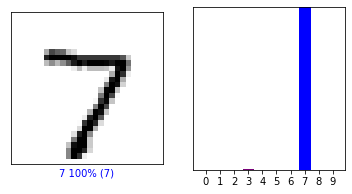

In [ ]:
i = 0  # 顯示第0號影像的辨識結果
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)  # 左圖
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  test_labels)  # 右圖
plt.show()  # 顯示

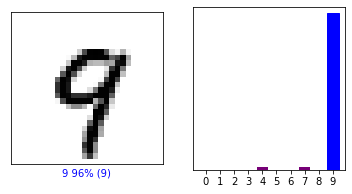

In [ ]:
i = 12  # 顯示第12號影像的辨識結果
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.


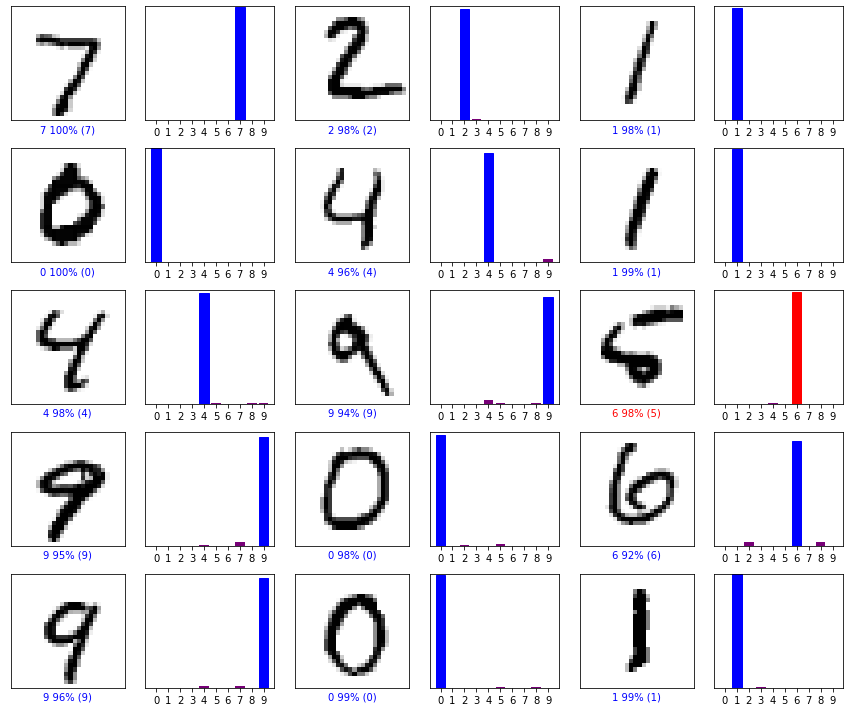

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.


In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a _batch_, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:


In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img, 0))  # 在第0維增加維度，以符合模式所需的輸入資料格式

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:


In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.9650240e-03 6.3698662e-06 9.8049635e-01 8.8747879e-03 1.1878687e-10
  5.7741692e-03 2.1164264e-03 4.1468818e-11 7.6690631e-04 2.0429271e-10]]


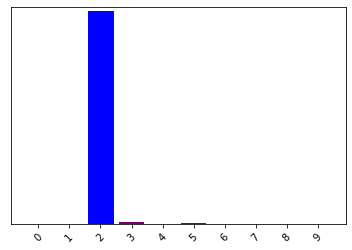

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:


In [ ]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.
